In [187]:

# before running: 
# mkdir /wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling

import os
#os.environ['PATH'] = "/wrk-vakka/group/spacephysics/proj/appl/tex-basic/texlive/2023/bin/x86_64-linux:" + os.environ['PATH']
print(os.environ["PATH"])

import matplotlib
#matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import ftest as ft
import pytools as pt
#from numba import jit
from myutils import cartesian_to_spherical, spherical_to_cartesian, mkdir_path, timer, timeseries, get_vlsvfile_fullpath
import scipy
import statsmodels.api as sm


global R_EARTH
R_EARTH = 6371000.
run = "FHA"  # FHA, FIA, EGL

'''
if run == "FIA":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/FIA/bulk_sidecars/ig_B"
elif run == "FHA":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/FHA/bulk1_sidecars/ig_B"
elif run == "EGL":
    dir = "/wrk-vakka/group/spacephysics/vlasiator/3D/EGL/sidecars/ig_B"
f = ft.f("/wrk-vakka/group/spacephysics/vlasiator/3D/FHA/bulk1_sidecars/ig_B/ionosphere_B_sidecar_FHA.0000784.vlsv")
'''

global START
global STOP
START = 501       # FHA: 501-1612 (probably need > 1100? for connection coordinates)
STOP = 1598  #1350 #1598 #1612 (XO sidecars only exist for t<=1598 if kernel crashes ask for more memory in jupyter_server.sh)
#only available after t~1100s in FHA: 'vg_connection', 'vg_connection_coordinates_fw', 'vg_j_parallel',
#dct = timeseries(run, ['vg_connection_coordinates_fw', 'ig_fac', 'vg_beta_star', 'ig_upmappednodecoords', 'proton/vg_pressure', 'proton/vg_precipitationdifferentialflux'], START, STOP) 
dct = timeseries(run, [ 'ig_fac', 'vg_beta_star', 'ig_upmappednodecoords', 'proton/vg_pressure', 'proton/vg_precipitationdifferentialflux'], START, STOP) 
dct_E_sidecar = timeseries(run, ['ig_E_north', 'ig_E_east'], START, STOP, filestem = '/wrk-vakka/users/horakons/carrington/data/FHA/GIC/ionosphere_gic_FHA_')
dct_XO_sidecar = timeseries(run, ['vg_lmn_neutral_line_distance', 'vg_dBNdL'], START, STOP, filestem='/wrk-vakka/group/spacephysics/vlasiator/3D/FHA/bulk1_sidecars/pysidecar_sdf_bulk1.')


#vg_fac_ts = dct['vg_j_parallel']
ig_fac_ts = dct['ig_fac']
vg_beta_star_ts = dct['vg_beta_star']
vg_pressure_ts = dct['proton/vg_pressure']
vg_precipitation_ts = dct['proton/vg_precipitationdifferentialflux']
ig_upmappednodecoords_ts = dct['ig_upmappednodecoords']                         # -3e-16 to 3e-16 
ig_E_north_ts = dct_E_sidecar['ig_E_north']
ig_E_east_ts = dct_E_sidecar['ig_E_east']
vg_lmn_nld_ts = dct_XO_sidecar['vg_lmn_neutral_line_distance']   # <0.2 to find XO lines (what are the units?)
vg_dBNdL_ts = dct_XO_sidecar['vg_dBNdL']                         # -3e-16 to 3e-16 


#>>> fw = f.read_parameter('vg_connection_coordinates_fw')
#Error: variable vg_connection_coordinates_fw/PARAMETER//pass not found in .vlsv file or in data reducers!

f = ft.f(get_vlsvfile_fullpath(run, STOP))
vg_coordinates = f.read_variable("vg_coordinates")
vg_r, vg_theta, vg_phi = cartesian_to_spherical(vg_coordinates[:,0], vg_coordinates[:,1], vg_coordinates[:,2])

#ig_coordinates = dct_E_sidecar['ig_r']   # this is locations of triangular elements (barycenters), NOT the same as node locations
ig_coordinates = f.get_ionosphere_node_coords()  # node locations (element corners): shape (21568, 3)



/wrk-vakka/appl/easybuild/opt/Anaconda3/2023.09-0:/wrk-vakka/appl/easybuild/opt/Anaconda3/2023.09-0/sbin:/wrk-vakka/appl/easybuild/opt/Anaconda3/2023.09-0/bin:/appl/easybuild/opt/ImageMagick/7.1.0-37-GCCcore-11.3.0/bin:/appl/easybuild/opt/LittleCMS/2.13.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/JasPer/2.0.33-GCCcore-11.3.0/bin:/appl/easybuild/opt/Ghostscript/9.56.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/GTK2/2.24.33-GCCcore-11.3.0/bin:/appl/easybuild/opt/Pango/1.50.7-GCCcore-11.3.0/bin:/appl/easybuild/opt/FriBidi/1.0.12-GCCcore-11.3.0/bin:/appl/easybuild/opt/HarfBuzz/4.2.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/ICU/71.1-GCCcore-11.3.0/sbin:/appl/easybuild/opt/ICU/71.1-GCCcore-11.3.0/bin:/appl/easybuild/opt/Gdk-Pixbuf/2.42.8-GCCcore-11.3.0/bin:/appl/easybuild/opt/LibTIFF/4.3.0-GCCcore-11.3.0/bin:/appl/easybuild/opt/libdeflate/1.10-GCCcore-11.3.0/bin:/appl/easybuild/opt/zstd/1.5.2-GCCcore-11.3.0/bin:/appl/easybuild/opt/lz4/1.9.3-GCCcore-11.3.0/bin:/appl/easybuild/opt/gzip/1.12-GCCcore-11.

In [188]:
# Fasil used a function like this to catch FTEs... not sure if I'll need it

def radial_line(theta, phi, r_arr, theta_arr, phi_arr,  delta = 2., r_range = [8*R_EARTH, 15*R_EARTH]):
    '''
        select all cells that "intersect" a radial line.

        Inputs:
            theta, phi: scalars specifying the radial line in spherical coordinates [degrees]
            theta_arr, phi_arr, r_arr: 1D arrays of cell locations in the grid 

        Returns:
            1D array of indices corresponding with the cells on the line

         indices where theta_arr and phi_arr are within delta of thet specified theta, phi
            AND r_arr is in r_range
    '''
    index = np.where( (np.abs(theta_arr - theta) < delta) & (np.abs(phi_arr-phi) < delta) 
                       & (r_arr > r_range[0]) & (r_arr < r_range[1]))[0]
    #print(index.size, ' points')
    #print(r_arr[index] / R_EARTH)
    return index

ind_line = radial_line(45., 0., vg_r, vg_theta*180./np.pi, vg_phi*180./np.pi, delta = 2., r_range = [8*R_EARTH, 9*R_EARTH]) 


In [189]:
# Select cells that map along the B-field to the point ig_testcoord
def calc_mindist_ind(array_2d, vec):
    # vec is 1D, N elements. Here, N=3 for 3D space
    # array_2d is [:, N]
    d = array_2d - vec
    d1 = np.linalg.norm( d, axis =1)
    return np.argmin(d1)


def vg_test_point_index(ig_testcoord, ind_vg, fw, ig_coordinates, vg_r, vg_theta, vg_coordinates, vg_lmn_nld_ts, vg_beta_star_ts, nld):
    # returns
    # ind_mindist: an index in the vg_grid that is near a null (X- or O-) point at some time
    #   connected along a field line to the point ig_testcoord
    #   steps:
    #   1. START with a list of inner magnetospheric indices, ind_vg, that are connected to ig_testcoord
    #   2. select the coordinate with the largest r from among those indexed by ind_vg, call it thiscoord
    #   3. from all times, from all null points on the SW side of the magnetopause, find the one that is nearest to thiscoord
    #   the index from (3) is returned as ind_mindist

    # from a given position, find the nearest neutral line position from all times
    this_vg_ind = ind_vg[-1] # use the point on the field line with largest vg_r
    thiscoord = vg_coordinates[this_vg_ind, :]
    ind_mindist = 0 # dummy
    mindist = R_EARTH * 1e6   # dummy
    for i in range(STOP - START + 1):
        # from all times, from all null points on the SW side of the magnetopause, find the one that is nearest to thiscoord
        ind_nl = np.where( (vg_lmn_nld_ts[i, :] < nld) & (vg_r > min_nl_radius) & (vg_beta_star_ts[i, :] > 1) & (vg_coordinates[:,0] > 9*R_EARTH))[0]   # check all times for neutral lines   
        d_nl = vg_coordinates[ind_nl, :] - thiscoord
        d1_nl = np.linalg.norm( d_nl, axis =1)
        i_nl = np.argmin(d1_nl)
        mindist_nl = d1_nl[i_nl]
        if mindist_nl < mindist:
            mindist = mindist_nl
            ind_mindist = ind_nl[i_nl]
            print(ind_mindist)
    return ind_mindist



In [190]:
def calc_XO_FTE(ind_vg_plot, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld=0.2, r_range=None, cleanup = False, nulls = 'XO'):
    # find nominal times when FTE (X or O line) passes through cell indexed by ind_vg_plot
    # nld: keyword setting the maximum distance to the nearest neutral line 
    # r_range = [r_min, r_max] or None
    # nulls: = 'XO', 'X', or 'O' 
    XO = np.zeros(vg_dBNdL_ts.shape[0])
    if r_range is None:
        ind_FTE_tmp = np.where(vg_lmn_nld_ts[:, ind_vg_plot] < nld)[0]
        # XO
        XO[ind_FTE_tmp] = np.sign(vg_dBNdL_ts[ind_FTE_tmp, ind_vg_plot])
    else:   # count as an FTE if *any* FTE on a radial line segment in [r_min, r_max]
        r, theta, phi = cartesian_to_spherical(vg_coordinates[:, 0], vg_coordinates[:, 1], vg_coordinates[:, 2])
        vg_inds = radial_line(theta[ind_vg_plot]*180./np.pi, phi[ind_vg_plot]*180./np.pi, r, theta*180./np.pi, phi*180./np.pi, delta = 2., r_range = r_range)
        #print(vg_inds.size)
        for vg_i in vg_inds:
            i_temp = np.where(vg_lmn_nld_ts[:, vg_i] < nld)[0]
            XO[i_temp] = np.sign(vg_dBNdL_ts[i_temp, vg_i])   # note, this is quite a klug, because and X and O null point could exist simultaneously on the same radial line
    if cleanup:     # handle duplicates that are at nearby times (count only the first in a series)
        dt = 30     # seconds (make this a keyword?)
        test = 0
        testind = 0
        for i, pm1 in enumerate(XO):
            if (pm1 != 0):
                if (pm1 == test) & (i-testind <= dt):
                    XO[i] = 0 # suppress duplicates that are at nearby times
                else:
                    test = pm1
                    testind = i
    if nulls == 'X':
        XO[XO < 0] = 0  # only count Xs
    elif nulls == 'O':
        XO[XO > 0] = 0  # only keep Os
    ind_FTE = np.where((XO != 0))[0]    
    # else do nothing (code finds Xs and Os by default)          
    return XO, ind_FTE


def plot_2vars(time, plot_var1, plot_var2, ylim1=None, ylim2=None, ylabel1='', ylabel2 = '', label1='', label2='', ccf = True):
    fig,ax1 = plt.subplots()
    ax2=ax1.twinx()
    # first plot
    ax1.plot(time, plot_var1, color = "C0", label = label1)
    ax1.set_ylabel(ylabel1,color="C0",fontsize=18)
    ax1.set_ylim([ylim1[0], ylim1[1]])
    # make a plot with different y-axis using second axis object
    ax2.plot(time, plot_var2, color = "C1", label = label2)
    ax2.set_ylabel(ylabel2, color="C1",fontsize=18)
    ax2.set_ylim([ylim2[0], ylim2[1]])
    ax1.legend(loc = 'upper center', framealpha = 1)
    ax2.legend(loc = 'lower center', framealpha = 1)
    if ccf: 
        this_ccf = sm.tsa.stattools.ccf(plot_var1, plot_var2, adjusted=False)
    plt.title('ccf = {}'.format(np.nanmax(np.abs(this_ccf))))
    plt.tight_layout()
    return fig, ax1, ax2



In [191]:
#fw = dct['vg_connection_coordinates_fw']   # shape (nfiles, 4012332, 3)
fw = np.repeat(f.read_variable('vg_connection_coordinates_fw')[None, :, :], STOP-START+1, axis = 0)

nld = 0.2   # can't catch further FTEs by increasing nld, becuase this proxy uses a linear approximation of the magnetic field (linear term in Taylor expansion) to estimate the location of nulls

### Pick the ionospheric point (index ind_ig_plot), and a magnetospheric point (index ind_vg_plot)

##############
'''

# APPROACH 1: pick an ionospheric point and find a magnetospheric point that is near its field line, 
# that also contains a null point at some time

# choose a point 'ig_testcoord' on the ionosphere (sphere at 1RE)
latitude = 80. * np.pi / 180.
theta = np.pi/2. - latitude
phi = 15. * np.pi / 180.
ig_testcoord = np.array(spherical_to_cartesian(R_EARTH, theta , phi ))

# Select cells that map along the B-field to the point ig_testcoord
#d_ig = ig_coordinates - ig_testcoord
#d1_ig = np.linalg.norm( d_ig, axis =1)
#ind_ig_plot = np.argmin(d1_ig)
ind_ig_plot = calc_mindist_ind(ig_coordinates, ig_testcoord)

#print(ig_coordinates[0, ind_ig_plot, :])
print(ig_coordinates[ind_ig_plot, :])
print(ig_testcoord)

# ind_vg: the indices of the vg_ grid that downmap to nearby (distance<delta_x) 
#         to a location ig_testcoord in the ionosphere.
#         also these vg_ grid locations are restricted in radius and to northern hemisphere (colatitude theta)
fw_test = fw[0,:,:]
d = fw_test - ig_testcoord
d1 = np.linalg.norm( d, axis =1)
delta_x = 2e5  # in meters,  1.2e5
min_nl_radius = 9* R_EARTH
ind_vg = np.where((d1 < delta_x) & (vg_r > 5.2*R_EARTH) & (vg_r < min_nl_radius) & (vg_theta < np.pi/2))[0]
# sort ind_vg by radius
i_temp = np.argsort(vg_r[ind_vg])
ind_vg = ind_vg[i_temp]

# ind_vg_plot is an index in the vg_grid, that is ~connected along a field line to the point ig_testcoord
ind_vg_plot = vg_test_point_index(ig_testcoord, ind_vg, fw, ig_coordinates, vg_r, vg_theta, vg_coordinates, vg_lmn_nld_ts, vg_beta_star_ts, nld)



##############

# APPROACH 2: pick the magnetospheric point, and find where it maps down to the ionosphere
# PICK a point in the magnetosphere, to make time series of FTEs

dct_cellid_to_vg_index = f.get_cellid_locations()
#vg_testcoord = np.array([10.444467116622194, 1.15696123057604772, 2.2595824831266675])*R_EARTH  # location of an FTE in FHA run, t=1125s (verified in visit)
vg_testcoord = np.array([6.762015382200596, 0.31392246115209543, 8.203107832365406]) * R_EARTH  # cusp FTE, t=1420s
#vg_testcoord = np.array([9.5, 0.86, 3.69]) * R_EARTH  # cusp FTE, t=1420s
#vg_testcoord = np.array([10.67562392089154, 0.15696123057604772, 0.5280897818238895]) * R_EARTH # equatorial FTE t=1420s
cellid_testcoord = f.get_cellid(vg_testcoord)
ind_vg_plot = dct_cellid_to_vg_index[cellid_testcoord]
print(vg_coordinates[ind_vg_plot, :]/R_EARTH)  # ~matches (as expected)

ig_testcoords = fw[:,ind_vg_plot,:]   # where magnetospheric point maps to, all times
ig_radius = np.linalg.norm(ig_testcoords, axis = -1)
ind_temp = np.where(ig_radius < 1.5 *R_EARTH)[0]  # only consider points that map to the ionosphere
ig_testcoord = ig_testcoords[ind_temp[0],:]       # pick first point, arbitrarily

ind_ig_plot = ind_temp[calc_mindist_ind(ig_coordinates[ind_temp,:], ig_testcoord)]

'''

##############

# APPROACH 3: Hard code both the ig and vg test coordinates

ind_ig_plot = 8       # ig index for plots I shared in meeting ~15.3. found with np.argmin(np.abs(ig_ccfs - 0.10897546723564523))
ig_testcoord = ig_coordinates[ind_ig_plot, :]

#ig_testcoord = np.array([0.19, 0.05, 0.9884331034521254])*R_EARTH
#ind_ig_plot = calc_mindist_ind(ig_coordinates, ig_testcoord)

vg_testcoord = vg_coordinates[242520,:]
#vg_testcoord = np.array([9.5, 0.86, 3.69])*R_EARTH
ind_vg_plot = calc_mindist_ind(vg_coordinates, vg_testcoord)


##############


# PLOT magnetospheric XO proxies overlaid on mapped ionospheric variables
#ind_plot_list = ind_vg[-2:-1]    # ind_vg
ind_plot_list = [ind_vg_plot]
time = np.arange(START, STOP+1)
for i, i_vg in enumerate(ind_plot_list):
    # vg XO proxy (-1 to 1) vs. ig FACs
    ylim2 = [-4e-7, 4e-7]
    #XO, ind_FTE = calc_XO_FTE(i_vg, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = [vg_r[i_vg]-R_EARTH, vg_r[i_vg]+R_EARTH], cleanup=True, nulls = 'O')
    XO, ind_FTE = calc_XO_FTE(i_vg, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = None, cleanup=True, nulls = 'O')
    #print(ind_FTE)
    fig, ax1, ax2 = plot_2vars(time, vg_pressure_ts[:,i_vg], ig_fac_ts[:, ind_ig_plot], ylim1=[None, None], ylim2=ylim2, 
                               ylabel1=r'Thermal Pressure [Pa]', ylabel2 = r'ig_fac $[A/m^2]$', 
                               label1= 'M-sphere {} RE'.format(np.array2string(vg_coordinates[i_vg, :] / R_EARTH, precision = 2)), 
                               label2='I-sphere {} RE'.format(np.array2string(ig_testcoord / R_EARTH, precision=2)))
#    fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts[:, ind_ig_plot], ylim1=[-1.5, 1.5], ylim2=ylim2, 
#                               ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'ig_fac $[A/m^2]$', 
#                               label1= 'M-sphere {} RE'.format(np.array2string(vg_coordinates[i_vg, :] / R_EARTH, precision = 2)), 
#                               label2='I-sphere {} RE'.format(np.array2string(ig_testcoord / R_EARTH, precision=2)))
    for i_FTE in ind_FTE:       # XO lines (vertical markers)
        ax2.plot([START + i_FTE, START + i_FTE], ylim2, linestyle ='--', color = 'C2')
    filename = '/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/mp_io_{}_vg_{}.png'.format(run, i)
    print(filename)
    plt.savefig(filename)
    plt.close()


print(ig_testcoord / R_EARTH)
print(vg_testcoord / R_EARTH)



/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/mp_io_FHA_vg_0.png
[ 0.12413408 -0.04533355  1.00709383]
[  7.6911003  -14.28347198   3.92403076]


In [192]:

# PLOT magnetospheric XO proxies overlaid on mapped ionospheric variables
#ind_plot_list = ind_vg[-2:-1]    # ind_vg
ind_plot_list = [ind_vg_plot]
time = np.arange(START, STOP+1)
for i, i_vg in enumerate(ind_plot_list):
    # vg XO proxy (-1 to 1) vs. ig FACs
    ylim2 = [-4e-7, 4e-7]
    XO, ind_FTE = calc_XO_FTE(i_vg, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = [vg_r[i_vg]-R_EARTH, vg_r[i_vg]+R_EARTH], cleanup=True, nulls = 'O')
    #print(ind_FTE)
    dnf_bin = 4
    fig, ax1, ax2 = plot_2vars(time, vg_pressure_ts[:,i_vg], vg_precipitation_ts [:, i_vg, dnf_bin], ylim1=[None, None], ylim2=ylim2, 
                               ylabel1=r'Thermal Pressure [Pa]', ylabel2 = 'DNF {} eV '.format(f.read_parameter('proton_PrecipitationCentreEnergy{}'.format(dnf_bin))) + '[SI units]', 
                               label1= 'M-sphere {} RE'.format(np.array2string(vg_coordinates[i_vg, :] / R_EARTH, precision = 2)), 
                               label2= 'M-sphere {} RE'.format(np.array2string(vg_coordinates[i_vg, :] / R_EARTH, precision = 2)))
    for i_FTE in ind_FTE:       # XO lines (vertical markers)
        ax2.plot([START + i_FTE, START + i_FTE], ylim2, linestyle ='--', color = 'C2')
    filename = '/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/mp_mp_{}_vg_{}.png'.format(run, i)
    plt.savefig(filename)
    plt.close()




In [193]:

# test ionosphere. Does mapping change with time? Answer, not really

plt.plot(time, ig_upmappednodecoords_ts[:, ind_ig_plot, 0]/R_EARTH, label = 'x')
plt.plot(time, ig_upmappednodecoords_ts[:, ind_ig_plot, 1]/R_EARTH, label = 'y')
plt.plot(time, ig_upmappednodecoords_ts[:, ind_ig_plot, 2]/R_EARTH, label = 'z')
plt.ylabel('Upmapped coordinate [R_E]')
plt.xlabel('time')
plt.title('Upmapping from {}'.format(np.array(ig_testcoord)/R_EARTH))
plt.legend()
plt.savefig('/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/ionosphere_upmappedcoords_{}.png'.format(run))   # make this mp_io_coupling/ directory
plt.close()


In [194]:
import statsmodels.api as sm

#calculate cross correlation
ccf = sm.tsa.stattools.ccf(XO,  ig_fac_ts[:, ind_ig_plot], adjusted=False)


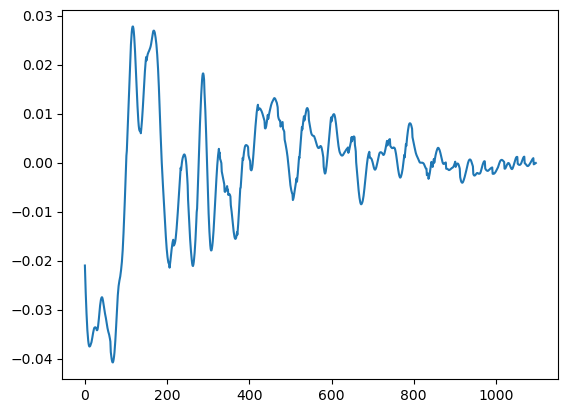

In [195]:
plt.plot(ccf)

In [196]:
ig_fac_ts_diff = np.diff(ig_fac_ts[:, ind_ig_plot], prepend=ig_fac_ts[0, ind_ig_plot])   # d(FAC)/dt, 
#ind_mpause = np.where((vg_coordinates[:,0] > 0) & (vg_r > 8*R_EARTH) & (vg_r < 12*R_EARTH))[0]
ind_mpause = np.where((vg_coordinates[:,0] > 0) & (vg_r > 8*R_EARTH) & (vg_r < 17*R_EARTH))[0]
ccf_max = 0.

# loop through magnetopause points (in vg grid), to see which are most correlated with the ig test point
vg_ccfs = np.zeros([vg_coordinates.shape[0]])

for i, i_m in enumerate(ind_mpause):
    #XO, ind_FTE = calc_XO_FTE(i_m, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = [vg_r[i_m]-R_EARTH, vg_r[i_m]+R_EARTH], cleanup=True, nulls = 'O')  # TOO SLOW
    XO, ind_FTE = calc_XO_FTE(i_m, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = None, cleanup=True, nulls = 'O')
    #print(i)
    #calculate cross correlation
    ccf = sm.tsa.stattools.ccf(XO,  ig_fac_ts[:, ind_ig_plot], adjusted=False)
    #ccf = sm.tsa.stattools.ccf(XO,  ig_fac_ts_diff, adjusted=False)
    ccf_temp = np.nanmax(np.abs(ccf))
    vg_ccfs[i_m] = ccf_temp
    if (ccf_temp > ccf_max or i_m == 242520) and len(np.where(XO <0)[0]) >= 3:
        print(i_m, ccf_max)
        ccf_max = np.nanmax([ccf_max, ccf_temp])
        #ylim2 = [-1e-8, 1e-8]   # for d/dt(FAC)
        #fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts_diff, ylim1=[-1.5, 1.5], ylim2=ylim2, 
        #                           ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'd/dt ig_fac $[A/m^2/s]$', 
        ylim2 = [-2e-7, 2e-7]   # for FAC
        fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts[:, ind_ig_plot], ylim1=[-1.5, 1.5], ylim2=ylim2, 
                                   ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'ig_fac $[A/m^2]$', 
        #ylim2 = [-2e-5, 2e-5]   # for E-field
        #fig, ax1, ax2 = plot_2vars(time, XO, ig_E_east_ts[:, ind_ig_plot], ylim1=[-1.5, 1.5], ylim2=ylim2, 
        #                           ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'E_north $[V/m]$', 
                                   label1= 'M-sphere {} RE'.format(np.array2string(vg_coordinates[i_m, :] / R_EARTH, precision = 2)), 
                                   label2= 'I-sphere {} RE'.format(np.array2string(ig_testcoord / R_EARTH, precision=2)))
        for i_FTE in ind_FTE:   # XO lines (vertical markers)
            ax2.plot([START + i_FTE, START + i_FTE], ylim2, linestyle ='--', color = 'C2')
        plt.savefig('/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/mp_io_{}_vg_{}.png'.format(run, i_m))
        plt.close()

ccf_max
#ind_mpause.size

26-Mar-24 22:03:17: /wrk-vakka/users/horakons/tmp/ipykernel_341841/2992450927.py:16: RuntimeWarning: All-NaN slice encountered
  ccf_temp = np.nanmax(np.abs(ccf))



6932 0.0
6944 0.020950989586795695


7433 0.03903656593166005
7477 0.06802028330145614
10465 0.09222773219400894
10890 0.10311121091779304
12097 0.10887448319163437
12197 0.10962394303299583
17097 0.11332637098262371
23003 0.12452439552755976
23640 0.1420768723323642
25085 0.14516658192180013
68846 0.15784824938906625
70148 0.16331437050920822
81072 0.16466829587612233
242520 0.1665718721093564


0.1665718721093564

In [197]:


# loop through ionosphere points (in ig grid), to see which are most correlated with the vg test point
ig_n = ig_coordinates.shape[0]
ig_ccfs = np.zeros(ig_n)
#XO, ind_FTE = calc_XO_FTE(ind_vg_plot, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = [vg_r[ind_vg_plot]-R_EARTH, vg_r[ind_vg_plot]+R_EARTH], cleanup=True, nulls = 'O')
XO, ind_FTE = calc_XO_FTE(ind_vg_plot, vg_coordinates, vg_lmn_nld_ts, vg_dBNdL_ts, nld = nld, r_range = None, cleanup=True, nulls = 'O')


ccf_max = 0.


for i_i in range(ig_n):
    #calculate cross correlation
    ig_fac_ts_diff = np.diff(ig_fac_ts[:, i_i], prepend=ig_fac_ts[0, i_i])   # d(FAC)/dt, 
    #ccf = sm.tsa.stattools.ccf(XO,  ig_fac_ts_diff, adjusted=False)
    ccf = sm.tsa.stattools.ccf(XO,  ig_fac_ts[:, i_i], adjusted=False)
    ccf_temp = np.nanmax(np.abs(ccf))
    ig_ccfs[i_i] = ccf_temp
    if ccf_temp > ccf_max:
        ccf_max = np.nanmax([ccf_max, ccf_temp])
        print(i_i, ccf_max)
        ylim2 = [-1e-7, 1e-7]
        fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts[:, i_i], ylim1=[-1.5, 1.5], ylim2=ylim2, 
                                   ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'ig_fac $[A/m^2]$', 
        #fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts_diff, ylim1=[-1.5, 1.5], ylim2=ylim2, 
        #                           ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'ig_fac $[A/m^2]$', 
        #ylim2 = [-2e-7, 2e-7]   # for FAC
        #fig, ax1, ax2 = plot_2vars(time, XO, ig_fac_ts[:, ind_ig_plot], ylim1=[-1.5, 1.5], ylim2=ylim2, 
        #                            ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'ig_fac $[A/m^2]$', 
        #ylim2 = [-2e-5, 2e-5]   # for E-field
        #fig, ax1, ax2 = plot_2vars(time, XO, ig_E_east_ts[:, ind_ig_plot], ylim1=[-1.5, 1.5], ylim2=ylim2, 
        #                            ylabel1=r'sign($dB_N/dL$) [X=1, O=-1]', ylabel2 = r'E_north $[V/m]$', 
                                    label1= 'M-sphere {} RE'.format(np.array2string(vg_testcoord / R_EARTH), precision = 2), 
                                    label2= 'I-sphere {} RE'.format(np.array2string(ig_coordinates[i_i, :] / R_EARTH), precision=2))
        for i_FTE in ind_FTE:   # XO lines (vertical markers)
            ax2.plot([START + i_FTE, START + i_FTE], ylim2, linestyle ='--', color = 'C2')
        plt.savefig('/wrk-vakka/users/horakons/carrington/plots/FHA/mp_io_coupling/mp_io_{}_ig_{}.png'.format(run, i_i))
        plt.close()

ccf_max


0 0.06993418690106784
1 0.08331612512433692
5 0.09460175361490705
7 0.10625268584942148
8 0.11490609575834101
50 0.12635357965248037
77 0.12999917982897724
93 0.13482846919672362
2321 0.20177925520140308


0.20177925520140308

In [198]:
vg_coordinates.shape

(4012332, 3)

In [199]:
fw[0,242520,:] / R_EARTH

array([  7.2078686, -12.219812 , -52.746124 ], dtype=float32)

In [200]:
242520 in ind_mpause

True

In [201]:
np.linalg.norm(vg_coordinates[242520,:]/R_EARTH)

16.690374864272258

In [202]:
ig_ccfs.shape
i = np.argmin(np.abs(ig_ccfs - 0.10897546723564523))
ig_ccfs[i]
ig_coordinates[i]/R_EARTH
#fw[7, 2425420,:]/R_EARTH
#np.arctan(1.007 / 0.123) * 180 / np.pi
i

10410